# EBLP Covariance Matrix Estimation - California School Data
We compare our block covariance matrix $G$ estimation method against the baseline that uses near PD for increaingly larger school sizes. This amounts to scaling the random effect covariance matrices $R_s$ by $1/\sqrt{n}$, if all schools are $n$ times larger, and comparing the $M_s$ EBLP estimates vs. the known correct limit, which is the average of student scores in the chool.

In [26]:
import collections
import cProfile
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from numpy.linalg import norm, eig, inv
import scipy
from scipy.linalg import eigh

import cpd
from cpd.moment_functional import f

np.set_printoptions(linewidth=150, precision=3, suppress=False)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Data

In [4]:
DATA_DIR = "../data/eblp_ca"
a_file_name = os.path.join(DATA_DIR, "A.txt")
c_file_name = os.path.join(DATA_DIR, "C.txt")
w_file_name = os.path.join(DATA_DIR, "Weights_BxB.txt")
pi_file_name = os.path.join(DATA_DIR, "Pi_s.txt")

r_file_name = os.path.join(DATA_DIR, "R_s.txt")
mu_file_name = os.path.join(DATA_DIR, "mu_s.txt")
# Baseline G estimate.
g_file_name = os.path.join(DATA_DIR, "G.txt")
y_file_name = os.path.join(DATA_DIR, "Ytilde_s.txt")

a, c, w, r, p = cpd.data.load_data(a_file_name, c_file_name, w_file_name, pi_file_name)
print("P: len", len(p), "shape", p.shape)

P: len 869 shape (10, 9)


## 2. EBLP Covariance Matrix Estimation

### Comparison of LS solution with R-code
Baseline residual from Katherine's R-code: $\|f(G^*)\|/\|C\| \approx 0.04$.

In [5]:
gs = np.loadtxt(os.path.join(DATA_DIR, "Gstar.txt"))

# gs = np.loadtxt(os.path.join(DATA_DIR, "Gstar_notWtd.txt"))
# w = np.ones_like(w)

lam_g = np.sort(np.linalg.eig(gs)[0])
print("lam(G^*) {}".format(np.array2string(lam_g, precision=1)))
g_vector =  cpd.linalg.unravel_lower(gs)

# Convert to unraveled form.
d = cpd.linalg.norm_weight_matrix(p.shape[0])
w_vector = cpd.linalg.unravel_lower(w)
w_matrix = np.diag(w_vector)

h = w_matrix @ cpd.moment_functional.matrix_function_to_matrix_sum(p, p)
c_vector = w_matrix @ cpd.linalg.unravel_lower(c)
# Solve LS problem.
g_ls_vector = np.linalg.lstsq(h, c_vector, rcond=None)[0]
g_ls = cpd.linalg.ravel_lower(g_ls_vector, symmetric=True)

n = len(c_vector)
print("|baseline - LS solution|/|basline| {:.4e} residual baseline {:.8e} LS {:.8e} {:.8e}".format(
    norm(np.array(g_vector).flatten() - np.array(g_ls_vector).flatten()) / norm(np.array(g_vector).flatten()),
    norm(w * (f(gs, p) - c)) / norm(w * c),
    norm(w * (f(g_ls, p) - c)) / norm(w * c),
    norm(d @ (h @ g_ls_vector - c_vector)) / norm(d @ c_vector)))

# plt.plot(lam, 'o', label="$A G^* A^T$")
# plt.xlabel("$i$")
# plt.ylabel("$\lambda_i$")
# plt.legend();

lam(G^*) [-28.6   8.7  48.5  63.6  77.1 163.4 258.2 288.5 389.3]
|baseline - LS solution|/|basline| 3.4245e-15 residual baseline 6.56198352e-02 LS 6.56198352e-02 6.56198352e-02


### $G^*$ Estimation using Regularized Cholesky Optimization (RCO)
In this section, we omit the $*$ superscript, as our unknown is $G^*$ all along.

#### Recoding $G$ to a vector
The functional to minimize is

$$ \min_G f(G) := \| \sum_i P_i ^T G P_T - C \|\ / \|C\|\,, $$
where $\|\cdot\|$ is the Frobenius norm.

Each term is of the form $P G P^T$. More generally, when we write $G = LL^T$ and freeze one of the terms in the Cholesky product, we will obtain terms of the form $P L L_{prev}^T P^T = P L (P L_{prev})^T = P L Q^T$ where $P \not = Q$. So we first focus on recoding the function 

$$P G Q^T$$ 

into the form $H g$, where $g$ consists of the lower-dimensional part of $G$ (including the diagonal). Here
* $P: m \times n$.
* $G: n \times n$.
* $Q: m \times n$.
* $F: \frac{m (m+1)}{2} \times \frac{n (n+1)}{2}$.
* $g$: vector of size $\frac{n (n+1)}{2}$.

In the original equations, $m = B, n = B - 1$, and $Q = P$ in all terms appearing in $f$.

$$ (P LG Q^T)_{ij} = \sum_{l,k=0}^{n-1} P_{ik} Q_{jk} G_{kl} = \sum_{r=0}^{n(n-1)/2} P_{ik} Q_{jk} g_{r(k,l)}$$

Thus the entire functional $h(G) = \sum_i P_i ^T G P_T $ can be written as $H g$ for some matrix $H$.

#### Explicit Equation for the flattened $L$
Assuming $G$ The functional $h(G = L L^T)$

$$ h(G) = \sum_i \left(l^T A_i l - c_i\right)^2  $$

#### Regularization
Maximize $G'$'s, i.e. $L$'s determinant, under constant norm.

$$ \min_l \sum_i \left(l^T A_i l - c_i\right)^2 - \alpha \left(
\sum_{i=0}^{n-1} \log(l_i^2) - \log \left(\sum_{i=0}^{n-1} l_i ^2\right) \right) $$
* Continuation in $\alpha$, starting from large $\alpha$ and decreasing it.
* BFGS for a fixed $\alpha$.
* L-curve for picking $\alpha$.

### ROC Comparison
We test the robustness of three emethods:
1. **Our method (RCO)** for minimizing the regularizd EBLP functional.
2. **Near-PD RCO**: finding the closest CPD matrix to the LS solution using RCO.
2. **Tanaka-Nakata (TN) method** for finding a closest CPD to the LS solution + picking optimal kappa on the curve.
3. **Basline: Higham Near PD** with eigenvalue tolerance of $\alpha$ as its regularization parameter (no continuation is possible in near PD, we start from scratch every time).

In [6]:
# Produce ROC curves for both methods.
methods = ("rco", "higham", "tn")
colors = ("b", "g", "k")

result = {}
for method in methods:
    print(method)
    optimizer = cpd.eblp.create_optimizer(method, p, w)
    result[method] = optimizer.optimize(c, num_alpha=200, alpha_step=0.9, tol_curve=1e-4, tol=1e-4)

rco
higham
tn


rco         : alpha 5.20e-03 knee (8.24e-02, 1.31e+02) index 86 final error 8.243e-02 8.243e-02 k(G) 1.31e+02
higham      : alpha 1.31e-05 knee (8.47e-02, 7.28e+04) index 63 final error 8.467e-02 8.467e-02 k(G) 7.28e+04
tn          : alpha 5.93e+01 knee (9.29e-02, 5.93e+01) index 104 final error 9.287e-02 9.287e-02 k(G) 5.93e+01


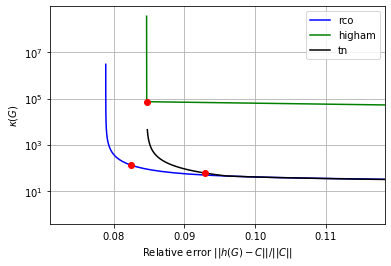

In [7]:
for i, method in enumerate(methods):
    g, out = result[method]
    info = out.info
    curve = out.curve
    index = out.index
    err = norm(w * (f(g, p) - c)) / norm(w * c)
    plt.semilogy(curve[:, 1], curve[:, 2], colors[i], label=method)
    plt.plot(curve[index, 1], curve[index, 2], 'ro')
    print("{:<11s} : alpha {:.2e} knee ({:.2e}, {:.2e}) index {:2d} final error {:.3e} {:.3e} k(G) {:.2e}".format(
        method, info[0], curve[index, 1], curve[index, 2], index, info[1], err, info[2]))
plt.grid(True);
plt.xlabel("Relative error $||h(G) - C||/||C||$")
plt.ylabel("$\kappa(G)$")
plt.legend()
curve = result["rco"][1].curve
plt.xlim([0.9 * min(curve[:, 1]), 1.5 * min(curve[:, 1])]);

CSPD producess both a more conditioned matrix (condition number is reduced by 1000x) and a smaller residual (by 3%). The ROC curve is smoother, allowing more freedom in choosing the regularization parameter $\alpha$. Even in the limit $\alpha \rightarrow 0$, the condition number tends to a finite limit.

Note that Near CPD's curve has a "wiggle" for small $\alpha$. That's because we are optimizing the Frobenius norm, so $f(G(\alpha))$ is not guaranteed to be monotonic in $\alpha$.

In [8]:
# Solution with default parameters.
for method in methods:
    optimizer = cpd.eblp.create_optimizer(method, p, w)
    %time g, r = optimizer.optimize(c, leeway_factor=1.1)
    info = r.info
    print("{:<8s} : alpha {:.3e} rel. error {:.3e} k(G) {:.3e}".format(method, info[0], info[1], info[2]))

CPU times: user 223 ms, sys: 1.39 ms, total: 224 ms
Wall time: 225 ms
rco      : alpha 4.481e-03 rel. error 8.196e-02 k(G) 1.483e+02
CPU times: user 27 ms, sys: 170 µs, total: 27.2 ms
Wall time: 27.3 ms
higham   : alpha 1.000e-06 rel. error 8.467e-02 k(G) 7.278e+04
CPU times: user 42.1 ms, sys: 515 µs, total: 42.6 ms
Wall time: 22.3 ms
tn       : alpha 1.607e+02 rel. error 8.758e-02 k(G) 1.607e+02


In [9]:
for method in ("rco", "tn"):
    print(method)
    optimizer = cpd.eblp.create_optimizer(method, p, w)
    g, r = optimizer.optimize(c)
    np.set_printoptions(precision=4)
    print("g")
    print(g)
    print("{:.8e}".format(norm(w * (f(g, p) - c)) / norm(w * c)))
    print(r.info, r.curve, r.index)

rco
g
[[216.5213 -10.7976  -5.1195 -73.4388 -13.9488  87.3209 -39.0781  -9.197  -42.6799]
 [-10.7976 199.2488 -28.0483 -40.441  -42.3751  -4.1998  57.7488 -63.4078 -20.9321]
 [ -5.1195 -28.0483 150.0849 -57.752  -22.8204  -5.9921 -25.6341  82.639  -77.7462]
 [-73.4388 -40.441  -57.752  149.5527  15.4365 -49.6865  13.3969 -42.925   78.8361]
 [-13.9488 -42.3751 -22.8204  15.4365 172.3585 -44.215  -49.5637 -27.4847  16.7758]
 [ 87.3209  -4.1998  -5.9921 -49.6865 -44.215  127.9799 -20.7062 -11.2941 -44.4908]
 [-39.0781  57.7488 -25.6341  13.3969 -49.5637 -20.7062  82.2182   6.5164  -8.6413]
 [ -9.197  -63.4078  82.639  -42.925  -27.4847 -11.2941   6.5164 103.531  -40.7159]
 [-42.6799 -20.9321 -77.7462  78.8361  16.7758 -44.4908  -8.6413 -40.7159  99.6717]]
8.19571300e-02
(0.004480974059329788, 0.08195712999487802, 148.28549465425962) [[4.4810e+01 9.9225e-01 1.0018e+00]
 [4.4810e-01 2.2641e-01 1.8558e+01]
 [4.4810e-03 8.2020e-02 1.4521e+02]
 [4.4810e-05 7.8925e-02 8.6016e+03]
 [4.4810e-07 7

In [10]:
result["tn"][1].curve, r.curve, result["tn"][1].index, r.index

(array([[4.4577e+03, 8.4754e-02, 4.4577e+03],
        [4.2763e+03, 8.4759e-02, 4.2763e+03],
        [4.1023e+03, 8.4763e-02, 4.1023e+03],
        [3.9354e+03, 8.4768e-02, 3.9354e+03],
        [3.7753e+03, 8.4773e-02, 3.7753e+03],
        [3.6217e+03, 8.4778e-02, 3.6217e+03],
        [3.4744e+03, 8.4784e-02, 3.4744e+03],
        [3.3330e+03, 8.4789e-02, 3.3330e+03],
        [3.1974e+03, 8.4795e-02, 3.1974e+03],
        [3.0673e+03, 8.4801e-02, 3.0673e+03],
        [2.9425e+03, 8.4808e-02, 2.9425e+03],
        [2.8228e+03, 8.4814e-02, 2.8228e+03],
        [2.7080e+03, 8.4821e-02, 2.7080e+03],
        [2.5978e+03, 8.4828e-02, 2.5978e+03],
        [2.4921e+03, 8.4836e-02, 2.4921e+03],
        [2.3907e+03, 8.4844e-02, 2.3907e+03],
        [2.2935e+03, 8.4852e-02, 2.2935e+03],
        [2.2001e+03, 8.4860e-02, 2.2001e+03],
        [2.1106e+03, 8.4869e-02, 2.1106e+03],
        [2.0248e+03, 8.4879e-02, 2.0248e+03],
        [1.9424e+03, 8.4888e-02, 1.9424e+03],
        [1.8634e+03, 8.4898e-02, 1

## 3. EBLP Estimation for Increasingly Large School Size

In [11]:
# Load EBLP terms.
g = np.loadtxt(g_file_name)

y = pd.read_csv(y_file_name, delimiter=" ")
school_id = y["school"]
endpoints = np.array([i for i, (first, second) in enumerate(zip(school_id, school_id[1:])) if first != second])
y_school = np.split(y[y.columns[~y.columns.isin(["school"])]], endpoints + 1)
mu = pd.read_csv(mu_file_name, delimiter=" ")[["mu"]].values.flatten()
r = cpd.data.data_frame_to_array_list(pd.read_csv(r_file_name, delimiter=" "), subtract_diagonal_sums=False)

y = pd.read_csv(y_file_name, delimiter=" ")
school_id = y["school"]
endpoints = np.array([i for i, (first, second) in enumerate(zip(school_id, school_id[1:])) if first != second])

In [12]:
def eblp_estimate(y_school, r, g, mu, eps: np.ndarray) -> np.ndarray:
    s = 1   # School number.
    S = len(y_school)
    N = sum(x.shape[0] for x in y_school)
    ms = np.zeros((N, len(eps)))
    #print(ms.shape)
    start = 0
    for s in range(S):
        data = y_school[s]
        n = data.shape[0]
        ybar = data[["Y_sb"]].values.flatten()
        alpha = data[["alpha_sb"]].values.flatten()
        block_index = data[["blockid"]].values.flatten() - 1
        gs = g[block_index, :][:, block_index]
        rs = r[s][block_index, :][:, block_index]
        c = gs @ inv(rs)
        lam, d = eig(c)
        
        n = data.shape[0]
        u = np.ones((n, 1))
        uut = u @ u.T

        for i, e in enumerate(eps):
            m = d @ np.diag(lam / (lam + e)) @ inv(d)
            #print(alpha + mu[s] + m @ (ybar - alpha - mu[s]))
            #print(start, n)
            v_inv = inv(gs + e * rs)
            h = (uut @ v_inv) / (u.T @ v_inv @ u)
            mu_s = h @ (ybar - alpha)
            ms[start:start+n, i] = alpha + mu_s + m @ (ybar - alpha - mu_s)
#        ms[s] = alpha + mu[s] + gs @ np.linalg.solve(gs + eps * rs, ybar - alpha - mu[s])
#        rs_inv = np.linalg.inv(rs)
#        z = np.linalg.solve(rs, ybar - alpha - mu[s])
#        print(rs_inv @ gs + eps * np.eye(len(block_index)))
#        w = np.linalg.solve(rs_inv @ gs + eps * np.eye(len(block_index)), z)
#        ms[s] = (alpha + mu[s] + gs @ w).flatten()
        start += n
    return ms

In [13]:
ms = eblp_estimate(y_school, r, g, mu, [1])
average = y[["blp"]].values.flatten()
norm(np.concatenate(tuple(ms)) - average) / norm(average)

2.8125922455587685e-15

In [14]:
average = y[["Y_sb"]].values.flatten()
eps_values = np.logspace(-10, 0, base=10, num=20)

# Baseline G.
g = np.loadtxt(os.path.join(DATA_DIR, "G.txt"))
m = eblp_estimate(y_school, r, g, mu, eps_values)
error = norm(m - average[:, None], axis=0) / norm(average)

optimizer = cpd.eblp.create_optimizer("rco", p, w)
gstar = optimizer.optimize(c)[0]
g_rco = a @ gstar @ a.T
m1 = eblp_estimate(y_school, r, g_rco, mu, eps_values)
error_rco = norm(m1 - average[:, None], axis=0) / norm(average)

optimizer = cpd.eblp.create_optimizer("tn", p, w)
gstar = optimizer.optimize(c)[0]
g_tn = a @ gstar @ a.T
m1 = eblp_estimate(y_school, r, g_tn, mu, eps_values)
error_tn = norm(m1 - average[:, None], axis=0) / norm(average)

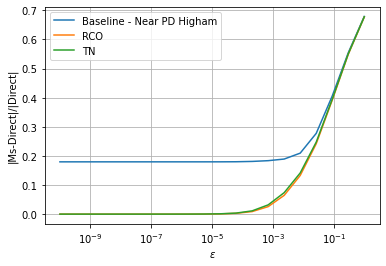

In [15]:
plt.semilogx(eps_values, error, label="Baseline - Near PD Higham")
plt.semilogx(eps_values, error_rco, label="RCO")
plt.semilogx(eps_values, error_tn, label="TN")
plt.grid(True)
plt.legend()
plt.xlabel("$\epsilon$")
plt.ylabel("|Ms-Direct|/|Direct|");
plt.savefig("bias.png")

In [ ]:
print((error_rco - error_tn) / error_rco)
print(error_rco - error_tn)

The TCO method is about $1/3$ smaller as $\epsilon \rightarrow 0$, but for large $\epsilon \geq 10^{-3}$, when the bias is non-zero, the differrence is very small. That is, the absolute difference is always small.

In [20]:
l = eig(g_tn)[0]
l[1] / l[-1]

124.36915073721056

In [21]:
l = eig(g_rco)[0]
l[1] / l[-1]

97.06928441673769

## Method Comparison - Katherine's Simulation
We've observed that RCO is better than TN during the simulation in terms of $G$ estimation and MSE. Let's compare the ROC curves for a particular case.

In [23]:
Out = collections.namedtuple('Out', ['curve', 'index'])

rco = Out(curve=np.array([
    [4.515031e+01, 0.9960176, 1.000787e+00],
    [4.515031e-01, 0.3132789, 2.798082e+01],
    [4.515031e-03, 0.1367898, 2.710231e+02],
    [4.515031e-05, 0.1315257, 2.214078e+04],
    [4.515031e-07, 0.1314593, 2.907558e+06],
]), index=2)

tn =  Out(curve=np.array([
    [4541.065865, 0.1369434, 4541.065865],
[859.022972, 0.1382860, 859.022972],
[162.499397, 0.1456051, 162.499397],
[30.739637, 0.2067012, 30.739637],
[5.814946, 1.0097155, 5.814946],
         ]),
          index=2)

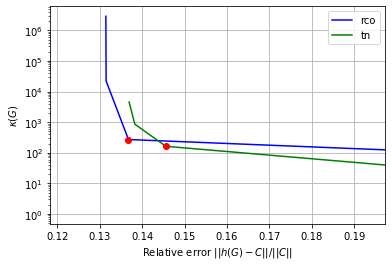

In [25]:
result = {"rco": rco, "tn": tn}
methods = result.keys()

for i, method in enumerate(methods):
    out = result[method]
    #info = out.info
    curve = out.curve
    index = out.index
    #err = norm(w * (f(g, p) - c)) / norm(w * c)
    plt.semilogy(curve[:, 1], curve[:, 2], colors[i], label=method)
    plt.plot(curve[index, 1], curve[index, 2], 'ro')
    #print("{:<11s} : alpha {:.2e} knee ({:.2e}, {:.2e}) index {:2d} final error {:.3e} {:.3e} k(G) {:.2e}".format(
    #    method, info[0], curve[index, 1], curve[index, 2], index, info[1], err, info[2]))
plt.grid(True);
plt.xlabel("Relative error $||h(G) - C||/||C||$")
plt.ylabel("$\kappa(G)$")
plt.legend()
curve = result["rco"].curve
plt.xlim([0.9 * min(curve[:, 1]), 1.5 * min(curve[:, 1])]);